# RMSProp

In the experiment in the ["Adagrad"](adagrad.md) section, the learning rate of each element in the independent variable of the objective function declines (or remains unchanged) during iteration because the variable $\boldsymbol{s}_t$ in the denominator is increased by the square by element operation of the mini-batch stochastic gradient, adjusting the learning rate. Therefore, when the learning rate declines very fast during early iteration, yet the current solution is still not desirable, Adagrad might have difficulty finding a useful solution because the learning rate will be too small at later stages of iteration. To tackle this problem, the RMSProp algorithm made a small modification to Adagrad[1].

## The Algorithm

We introduced EWMA (exponentially weighted moving average) in the ["Momentum"](momentum.md) section. Unlike in Adagrad, the state variable $\boldsymbol{s}_t$ is the sum of the square by element all the mini-batch stochastic gradients $\boldsymbol{g}_t$ up to the time step $t$, RMSProp uses the EWMA on the square by element results of these gradients. Specifically, given the hyperparameter $0 \leq \gamma < 1$, RMSProp is computed at time step $t>0$.

$$\boldsymbol{s}_t \leftarrow \gamma \boldsymbol{s}_{t-1} + (1 - \gamma) \boldsymbol{g}_t \odot \boldsymbol{g}_t. $$

Like Adagrad, RMSProp re-adjusts the learning rate of each element in the independent variable of the objective function with element operations and then updates the independent variable.

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t, $$

Here, $\eta$ is the learning rate while $\epsilon$ is a constant added to maintain numerical stability, such as $10^{-6}$. Because the state variable of RMSProp is an EWMA of the squared term $\boldsymbol{g}_t \odot \boldsymbol{g}_t$, it can be seen as the weighted average of the mini-batch stochastic gradient's squared terms from the last $1/(1-\gamma)$ time steps. Therefore, the learning rate of each element in the independent variable will not always decline (or remain unchanged) during iteration.

By convention, we will use the objective function $f(\boldsymbol{x})=0.1x_1^2+2x_2^2$ to observe the iterative trajectory of the independent variable in RMSProp. Recall that in the ["Adagrad"](adagrad.md) section, when we used Adagrad with a learning rate of 0.4, the independent variable moved less in later stages of iteration. However, at the same learning rate, RMSProp can approach the optimal solution faster.

epoch 20, x1 -0.010599, x2 0.000000


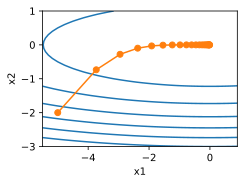

In [1]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import d2l
import math
from mxnet import nd

def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

## Implementation from Scratch

Next, we implement RMSProp with the formula in the algorithm.

In [2]:

features, labels = d2l.get_data_ch7()
def init_rmsprop_states():
    s_w = nd.zeros((features.shape[1], 1))
    s_b = nd.zeros(1)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        s[:] = gamma * s + (1 - gamma) * p.grad.square()
        p[:] -= hyperparams['lr'] * p.grad / (s + eps).sqrt()

We set the initial learning rate to 0.01 and the hyperparameter $\gamma$ to 0.9. Now, the variable $\boldsymbol{s}_t$ can be treated as the weighted average of the square term $\boldsymbol{g}_t \odot \boldsymbol{g}_t$ from the last $1/(1-0.9) = 10$ time steps.

loss: 0.244952, 0.388319 sec per epoch


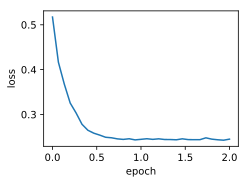

In [3]:
d2l.train_ch7(rmsprop, init_rmsprop_states(), {'lr': 0.01, 'gamma': 0.9},
              features, labels)

## Concise Implementation

From the `Trainer` instance of the algorithm named "rmsprop", we can implement the RMSProp algorithm with Gluon to train models. Note that the hyperparameter $\gamma$ is assigned by `gamma1`.

loss: 0.242340, 0.231425 sec per epoch


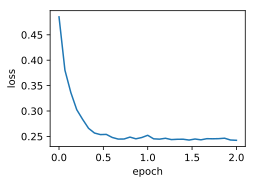

In [4]:
d2l.train_gluon_ch7('rmsprop', {'learning_rate': 0.01, 'gamma1': 0.9},
                    features, labels)

## Summary

* The difference between RMSProp and Adagrad is that RMSProp uses an EWMA on the squares of elements in the mini-batch stochastic gradient to adjust the learning rate.

## Exercises

* What happens to the experimental results if we set the value of $\gamma$ to 1? Why?
* Try using other combinations of initial learning rates and $\gamma$ hyperparameters and observe and analyze the experimental results.




## Reference

[1] Tieleman, T., & Hinton, G. (2012). Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude. COURSERA: Neural networks for machine learning, 4(2), 26-31.

## Scan the QR Code to [Discuss](https://discuss.mxnet.io/t/2376)

![](../img/qr_rmsprop.svg)